# Imports

In [3]:
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import linregress



# Question 1: Small World Phenomena in Random Networks

## Helpers

In [4]:
def generate_1d_lattice(N, k=2):
    assert k % 2 == 0, "k must be even"
    G =ig.Graph.Ring(n=N, directed=False, circular=True)
    if k == 2:
        return G
    max_dist = k // 2    
    dist = G.shortest_paths()
    edges = []
    for i in range(N):
        for j in range(i + 1, N):
            if 1 < dist[i][j] <= max_dist:
                edges.append((i, j))
    G.add_edges(edges)
    return G


In [5]:
def generate_2d_lattice(N, torus=True):
    L = int(np.sqrt(N))
    dims = [L, L]    
    G = ig.Graph.Lattice(dims, circular=torus, directed=False)
    
    return G


In [6]:
def generate_3d_lattice(N, torus=False):
    L = int(round(N ** (1/3)))
    dims = [L, L, L]  
    G = ig.Graph.Lattice(dims, circular=torus, directed=False)
    return G


In [7]:
def generate_random_network(N, k_avg=4):
    p = k_avg / (N - 1)
    return ig.Graph.Erdos_Renyi(n=N, p=p, directed=False)



In [8]:
def average_shortest_path(G):
    if G.is_connected():
        return G.average_path_length()
    else:
        clusters = G.clusters()  
        largest_cc = clusters.giant()  
        return largest_cc.average_path_length()


## Simulation

In [9]:
Ns = np.logspace(np.log10(500), np.log10(5000), num=30, dtype=int)
results = {'1D': [], '2D': [], '3D': [], 'RN': []}

for N in Ns:
    results['1D'].append(
        average_shortest_path(generate_1d_lattice(N))
    )
    results['2D'].append(
        average_shortest_path(generate_2d_lattice(N))
    )
    results['3D'].append(
        average_shortest_path(generate_3d_lattice(N))
    )

    # Random network: average over 5 realizations
    rn_vals = []
    for _ in range(5):
        rn_vals.append(
            average_shortest_path(generate_random_network(N))
        )
    results['RN'].append(np.mean(rn_vals))


C:\Users\Admin\AppData\Local\Temp\ipykernel_1112\1611763186.py:5: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  clusters = G.clusters()


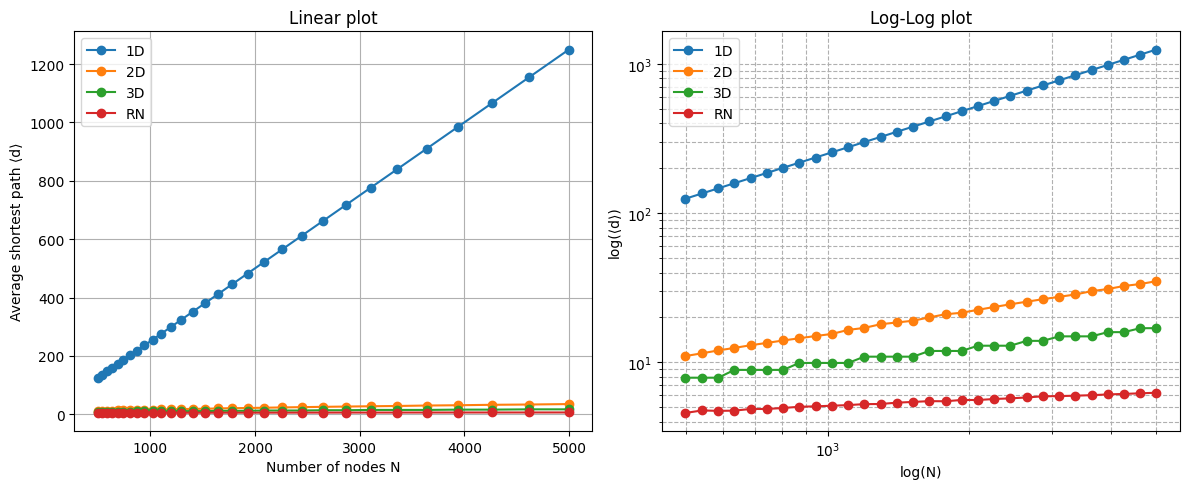

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for key, vals in results.items():
    plt.plot(Ns, vals, marker='o', label=key)
plt.xlabel('Number of nodes N')
plt.ylabel('Average shortest path ⟨d⟩')
plt.title('Linear plot')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for key, vals in results.items():
    plt.loglog(Ns, vals, marker='o', label=key)
plt.xlabel('log(N)')
plt.ylabel('log(⟨d⟩)')
plt.title('Log-Log plot')
plt.legend()
plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


1D lattice: scaling exponent a = 0.999, Intercept = -1.380147, Intercept_exp = 0.251541, R² = 1.000
2D lattice: scaling exponent a = 0.501, Intercept = -0.710036, Intercept_exp = 0.491627, R² = 1.000
3D lattice: scaling exponent a = 0.336, Intercept = -0.032540, Intercept_exp = 0.967983, R² = 0.988


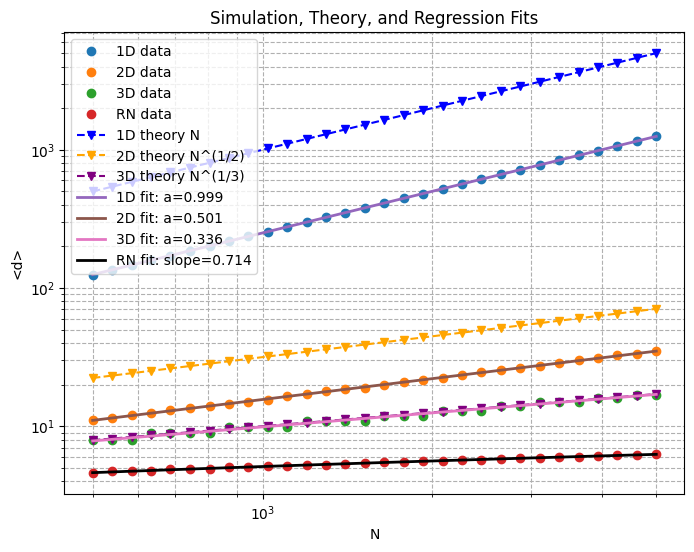

In [39]:
plt.figure(figsize=(8,6))

for key, vals in results.items():
    plt.loglog(Ns, vals, marker='o', linestyle='', label=f"{key} data")

plt.loglog(Ns, Ns**1, '--', color='blue', marker="v", alpha=1, label='1D theory N')
plt.loglog(Ns, Ns**0.5, '--', color='orange', marker="v", alpha=1, label='2D theory N^(1/2)')
plt.loglog(Ns, Ns**(1/3), '--', color='purple', marker="v", alpha=1, label='3D theory N^(1/3)')

for key in ['1D', '2D', '3D']:
    logN = np.log(Ns)
    logd = np.log(results[key])
    slope, intercept, r_value, _, _ = linregress(logN, logd)
    plt.loglog(Ns, np.exp(intercept) * Ns**slope, '-', linewidth=2, label=f'{key} fit: a={slope:.3f}')
    print(f"{key} lattice: scaling exponent a = {slope:.3f}, Intercept = {intercept:3f}, Intercept_exp = {np.exp(intercept):3f}, R² = {r_value**2:.3f}")

logdRN = np.array(results['RN'])
slope_ln, intercept_ln, _, _, _ = linregress(np.log(Ns), logdRN)
plt.plot(Ns, intercept_ln + slope_ln * np.log(Ns), 'k-', linewidth=2, label=f'RN fit: slope={slope_ln:.3f}')

plt.xlabel('N')
plt.ylabel('<d>')
plt.title('Simulation, Theory, and Regression Fits')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
